In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
import os

image_path = "/content/drive/MyDrive/Images"

# Klasördeki dosyaları listele
files = os.listdir(image_path)

# Dosya tiplerine göre sayacı başlat
jpg_count = 0
npy_count = 0

# Dosya tiplerine göre isimleri tutacak boş listeler oluştur
jpg_files = []
npy_files = []

# Dosya tiplerine göre sayacı ve isimleri hesapla
for file in files:
    # Dosya adının sonu ".jpg" ile biterse
    if file.endswith(".jpg"):
        jpg_count += 1
        jpg_files.append(file)
    # Dosya adının sonu ".npy" ile biterse
    elif file.endswith(".npy"):
        npy_count += 1
        npy_files.append(file)

print("JPG dosya sayısı:", jpg_count)
print("JPG dosyaları:", jpg_files)
print("NPY dosya sayısı:", npy_count)
print("NPY dosyaları:", npy_files)


JPG dosya sayısı: 8091
JPG dosyaları: ['3738685861_8dfff28760.jpg', '3730011701_5352e02286.jpg', '3726130458_07df79e969.jpg', '3759492488_592cd78ed1.jpg', '3726629271_7639634703.jpg', '400851260_5911898657.jpg', '381275595_b429fd1639.jpg', '384465370_9918873f9a.jpg', '385835044_4aa11f6990.jpg', '436393371_822ee70952.jpg', '444803340_fdcaab86f9.jpg', '415657941_454d370721.jpg', '439492931_a96d590e40.jpg', '441212506_fcc321ac28.jpg', '431282339_0aa60dd78e.jpg', '423066487_07757b2b49.jpg', '447722389_4b51b7e13d.jpg', '416788726_5b4eb1466e.jpg', '415118186_64defc96f3.jpg', '445861800_75fc6a8c16.jpg', '437054333_5c2761b8cd.jpg', '411216802_aead9e67e3.jpg', '412203580_2c7278909c.jpg', '431410325_f4916b5460.jpg', '444057017_f1e0fcaef7.jpg', '434938585_fbf913dfb4.jpg', '433810429_a4da0eac50.jpg', '432490118_54a9c0e500.jpg', '431018958_84b2beebff.jpg', '424506167_01f365726b.jpg', '449287870_f17fb825d7.jpg', '449352117_63c359c6e7.jpg', '426065353_e9a604a01f.jpg', '421932359_edbf181f44.jpg', '444

In [ ]:
dir_Flickr_text = "/content/drive/MyDrive/Flickr8k.token.txt"

In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)


In [ ]:
data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


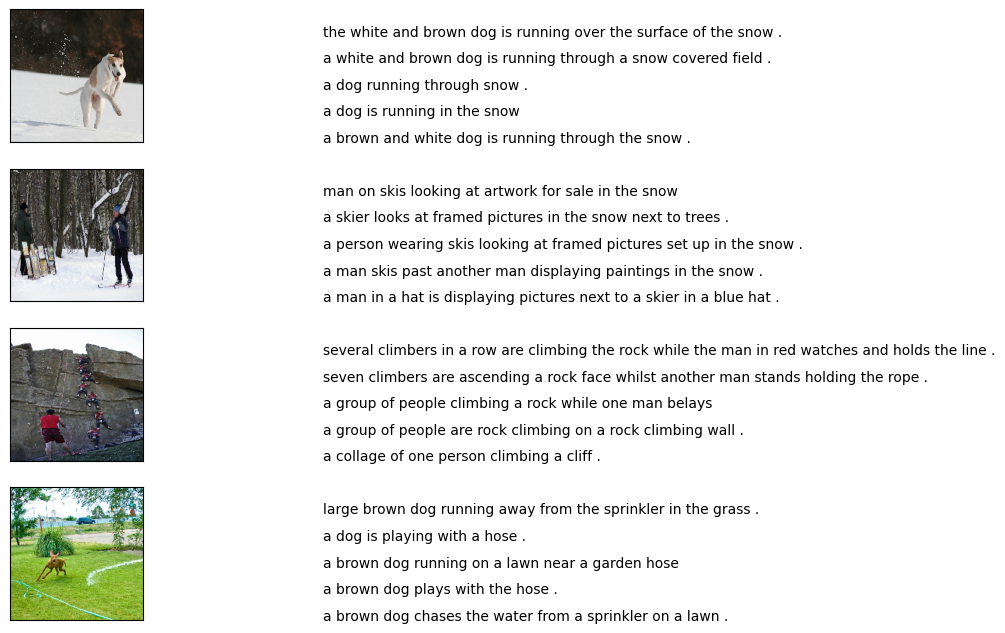

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,10))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=10)
   count += 1
plt.show()

In [ ]:
## Vocabulary Size 
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [ ]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [ ]:
## Vocabulary Size after cleaning

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [ ]:
all_captions = []
for caption in data["caption"].astype(str):
   caption = ' ' + caption+ ' '
   all_captions.append(caption)

all_captions[:10]

['  child in pink dress is climbing up set of stairs in an entry way ',
 '  girl going into wooden building ',
 '  little girl climbing into wooden playhouse ',
 '  little girl climbing the stairs to her playhouse ',
 '  little girl in pink dress going into wooden cabin ',
 '  black dog and spotted dog are fighting ',
 '  black dog and dog playing with each other on the road ',
 '  black dog and white dog with brown spots are staring at each other in the street ',
 '  two dogs of different breeds looking at each other on the road ',
 '  two dogs on pavement moving toward each other ']

In [ ]:
def seq(text):
    for i in range(len(all_captions)):
        caption = all_captions[i]
        captions = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
        all_captions[i] = captions
    return all_captions

In [ ]:
seq(all_captions)

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>',
 '<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
 '<start> little girl is sitting in front of large painted rainbow <end>',
 '<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>',
 '<start> 

In [ ]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
PATH = "/content/drive/MyDrive/Images/"

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)
     

In [ ]:
all_img_name_vector[:20]

['/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Images/1003163366_44323f5815.jpg',
 '/content/drive/MyDrive/Images/10031633

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(30000,all_captions,all_img_name_vector)
print(f"len(train_captions) : {len(train_captions)}")
print(f"len(img_name_vector) : {len(img_name_vector)}")

len(train_captions) : 30000
len(img_name_vector) : 30000


In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [1:40:48<00:00, 47.63s/it]


In [ ]:
top_k = 4000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index[''] = 0
tokenizer.index_word[0] = ''

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
train_captions[:3]

['<start> several children leaping into pile of leaves on the ground <end>',
 '<start> man hiking in the wilderness giving the camera thumbs up <end>',
 '<start> white dog is running through the water onto the shore <end>']

In [ ]:
train_seqs[:3]

[[2, 184, 63, 336, 64, 481, 12, 332, 6, 5, 167, 3],
 [2, 11, 663, 4, 5, 2258, 838, 5, 95, 1162, 54, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 231, 5, 276, 3]]

In [ ]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))
     

Max Length of any caption : Min Length of any caption = 33 : 2


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:

class VGG16_Encoder(tf.keras.Model):
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [ ]:
#rnn_type(units) fonksiyonu, bir RNN modeli için kullanılacak birim sayısına bağlı olarak, GPU kullanılabiliyorsa tf.compat.v1.keras.layers.CuDNNLSTM 
#veya aksi takdirde tf.keras.layers.GRU katmanlarını döndürür.
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

'''Kodlayıcı çıkışı (yani 'özellikler'), gizli durum (0 olarak başlatıldı) (yani 'hidden ') ve kod çözücü girişi (başlangıç belirteci olan) (yani 'x') kod çözücüye geçirilir.'''

'''Rnn_Local_Decoder sınıfı, yerel dil öğrenme modeli (Local Language Model) için bir decoder oluşturur. 
Bu sınıf, bir embedding katmanı, bir GRU katmanı, iki yoğun katman ve bir attention mekanizması içerir.'''


class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', 
                                                                moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention 
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):

   hidden_with_time_axis = tf.expand_dims(hidden, 1)
   # score shape == (64, 49, 1)
   # Attention
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
   attention_weights = tf.nn.softmax(score, axis=1)

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   x = self.embedding(x)
   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

   output, state = self.gru(x)

   x = self.fc1(output)
   x = tf.reshape(x, (-1, x.shape[2]))

   x= self.dropout(x)
   x= self.batchnormalization(x)

   x = self.fc2(x)

   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [ ]:

start_epoch = 0
EPOCHS = 5
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7035
Epoch 1 Batch 100 Loss 1.6596
Epoch 1 Batch 200 Loss 1.5340
Epoch 1 Batch 300 Loss 1.5026
Epoch 1 Batch 400 Loss 1.1283
Epoch 1 Batch 500 Loss 1.4353
Epoch 1 Batch 600 Loss 1.1561
Epoch 1 Batch 700 Loss 1.4700
Epoch 1 Batch 800 Loss 1.2692
Epoch 1 Batch 900 Loss 1.3442
Epoch 1 Batch 1000 Loss 1.0605
Epoch 1 Batch 1100 Loss 1.3530
Epoch 1 Batch 1200 Loss 1.1060
Epoch 1 Batch 1300 Loss 0.9948
Epoch 1 Batch 1400 Loss 0.9503
Epoch 1 Loss 1.334937
Time taken for 1 epoch 3745.7269978523254 sec

Epoch 2 Batch 0 Loss 1.2770
Epoch 2 Batch 100 Loss 1.1525
Epoch 2 Batch 200 Loss 1.1133
Epoch 2 Batch 300 Loss 1.1541
Epoch 2 Batch 400 Loss 0.9527
Epoch 2 Batch 500 Loss 1.0996
Epoch 2 Batch 600 Loss 1.0140
Epoch 2 Batch 700 Loss 1.0284
Epoch 2 Batch 800 Loss 0.9684
Epoch 2 Batch 900 Loss 0.9756
Epoch 2 Batch 1000 Loss 0.9673
Epoch 2 Batch 1100 Loss 0.9083
Epoch 2 Batch 1200 Loss 0.9382
Epoch 2 Batch 1300 Loss 1.1860
Epoch 2 Batch 1400 Loss 0.9519
Epoch 2 Loss 1.064580
Tim

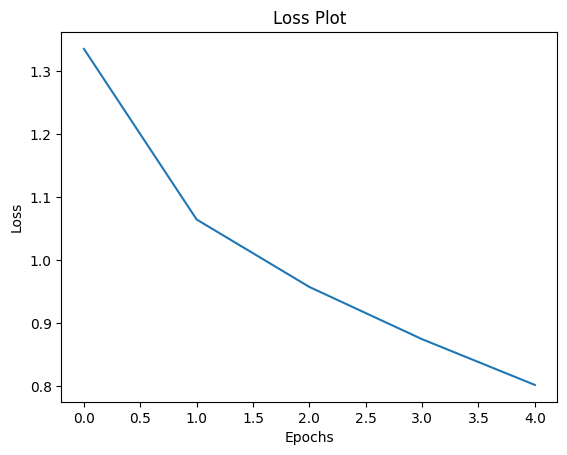

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot
     

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

BELU score: 9.039352811507815e-230
Real Caption: two men step off the bus together
Prediction Caption: three men wearing medal <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus <end> bus


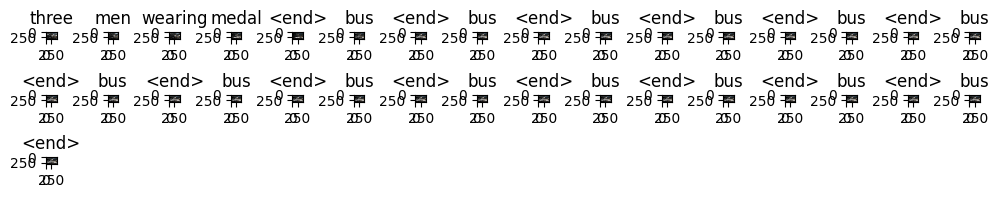

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in result:
   if i=="":
       result.remove(i)

for i in real_caption:
   if i=="":
       real_caption.remove(i)
  
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

BLEU score: 7.6011593754101815e-230
Real Caption:  black dog and spotted dog are fighting
Prediction Caption: dog is playing with each other <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


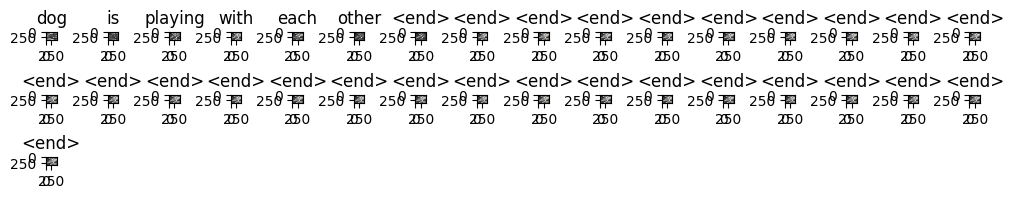

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove  and  from the real_caption
first = real_caption.split(' ', 1)[1]
filename = '1001773457_577c3a7d70.jpg'
real_caption = data.loc[data['filename'] == filename, 'caption'].values[0]

#remove "" in result
for i in result:
   if i=="":
       result.remove(i)

for i in real_caption:
   if i=="":
       real_caption.remove(i)

#remove  from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 1.6899545172934427e-76
Real Caption:  little girl covered in paint sits in front of painted rainbow with her hands in bowl
Prediction Caption: young girl in red dress is sitting in front of rainbow painting <end> rainbow painting <end> rainbow painting <end> rainbow painting <end> rainbow painting <end> rainbow painting <end> rainbow painting <end> rainbow


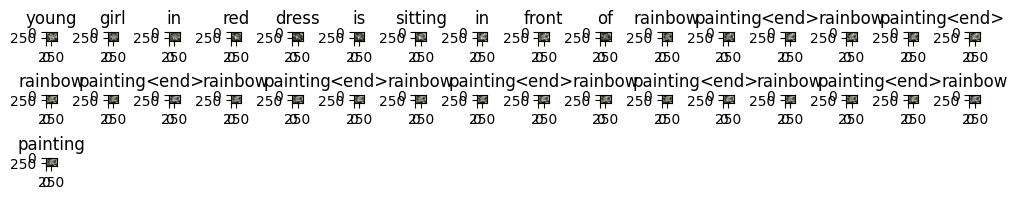

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/Images/1002674143_1b742ab4b8.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove  and  from the real_caption
first = real_caption.split(' ', 1)[1]
filename = '1002674143_1b742ab4b8.jpg'
real_caption = data.loc[data['filename'] == filename, 'caption'].values[0]

#remove "" in result
for i in result:
   if i=="":
       result.remove(i)

for i in real_caption:
   if i=="":
       real_caption.remove(i)

#remove  from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 3.912899894057541e-153
Real Caption:  man in hat is displaying pictures next to skier in blue hat
Prediction Caption: person skis in the skier in black hat and hat and woman in black hat and woman in black hat and woman in black hat and woman in black hat and woman


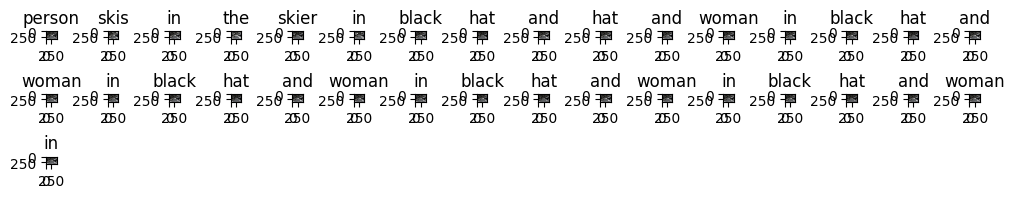

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/Images/101669240_b2d3e7f17b.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove  and  from the real_caption
first = real_caption.split(' ', 1)[1]
filename = '101669240_b2d3e7f17b.jpg'
real_caption = data.loc[data['filename'] == filename, 'caption'].values[0]

#remove "" in result
for i in result:
   if i=="":
       result.remove(i)

for i in real_caption:
   if i=="":
       real_caption.remove(i)

#remove  from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)